<a href="https://colab.research.google.com/github/Abmiester/BERT_sentiment/blob/master/tweet_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet reviews large dataset sentiment
We will be training a sentiment analysis model on large tweet dataset so that we can apply the model to tweets.

The end goal is to build a bot that whittles down the daily sentiment of famous figures on social media and tweet out their sentiment for the day.

In [1]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-07-13 18:57:11--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.229.170.137, 54.159.115.94, 54.84.89.161, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.229.170.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.11MB/s    in 2.1s    

2020-07-13 18:57:14 (6.11 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [2]:
!pip install watermark
!pip install transformers

     |████████████████████████████████| 778kB 2.6MB/s 
     |████████████████████████████████| 890kB 6.6MB/s 
     |████████████████████████████████| 3.0MB 9.0MB/s 
     |████████████████████████████████| 1.1MB 29.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1cbe2c9a66c806afa266e06df18e658cfee4cefb6a5e5e60c1aae3192e090dc3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
%load_ext tensorboard

In [4]:
%reload_ext watermark
%watermark -v -p numpy
print('----------')
%watermark -v -p pandas
print('----------')
%watermark -v -p torch
print('----------')
%watermark -v -p transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
----------
CPython 3.6.9
IPython 5.5.0

pandas 1.0.5
----------
CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101
----------
CPython 3.6.9
IPython 5.5.0

transformers 3.0.2


Create directory for logs to view tensorboard, when needed.

In [5]:
import os
import transformers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import rc
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# log path as runs, fire up the TensorBoard in the background
LOG_DIR = 'runs'
os.makedirs(LOG_DIR, exist_ok=True)
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR)
)

# run ngork to tunnel TensorBoard port 6006
get_ipython().system_raw('./ngrok http 6006 &')

In [7]:
# generate public URL
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://909069b9224e.ngrok.io


In [8]:
# LOG_DIR is runs, making it more specific here
writer = SummaryWriter('runs/tweet_sentiment')

In [9]:
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Get Data
We will use a cleaned tweet sentiment dataset to train a classifier. We got this data from this fairly large but dated [Kaggle source](https://www.kaggle.com/kazanova/sentiment140). It's dated because it's from a time when Twitter's character limit was 140, and emojis aren't included.

In [10]:
tweet_data = pd.read_csv('./sample_data/tweet_dataset.csv',
                         names=['sentiment', 'tweet_id', 'tweet_date', 'query_type', 'twitter_handle', 'tweet'],
                         header=None,
                         encoding='ISO-8859-1'
                         )
print('Number of tweets available: {}'.format(len(tweet_data)))

Number of tweets available: 1600000


In [11]:
tweet_data.shape

(1600000, 6)

In [12]:
# look for missing data in review and sentiment
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   sentiment       1600000 non-null  int64 
 1   tweet_id        1600000 non-null  int64 
 2   tweet_date      1600000 non-null  object
 3   query_type      1600000 non-null  object
 4   twitter_handle  1600000 non-null  object
 5   tweet           1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
# set machine targets
machine_sentiment = [1 if sentiment == 4 else 0 for sentiment in tweet_data.sentiment]
tweet_data['sentiment'] = machine_sentiment

Text(0.5, 0, 'Sentiment')

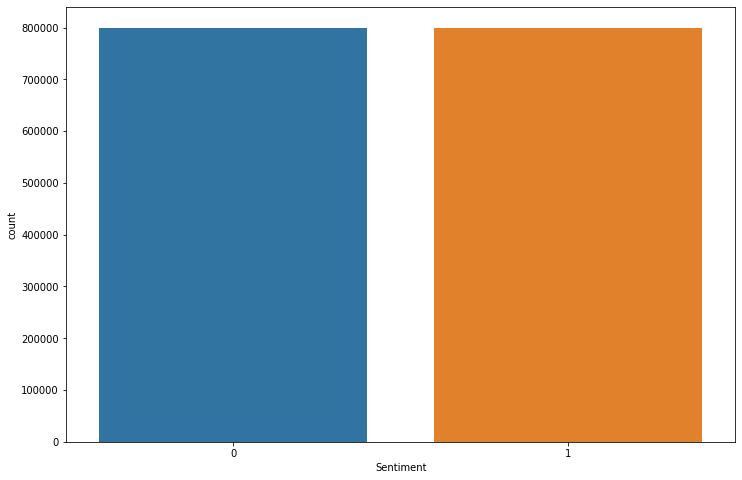

In [14]:
# check balance
sns.countplot(tweet_data.sentiment)
plt.xlabel('Sentiment')

## Preprocess Data
Requirements for BERT to work:
- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create arrays of 0s (pad token) and 1s (real token) called _attention mask_

Special tokens:
- [SEP] marker for ending sentences
- [CLS] must add this token to the start of each sentence so BERT knows that we're doing classification
- [UNK] encode everything not in the training set with this as BERT already understands tokens in the training set

In [15]:
# load a pre-trained BertTokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Choosing Sequence Length
We'll use a simple strategy to choose max length; find the largest length of tweet tokens.

In [16]:
word_lens = []

for txt in tweet_data.tweet:
  word_lens.append(len(txt))

Text(0.5, 0, 'Word count')

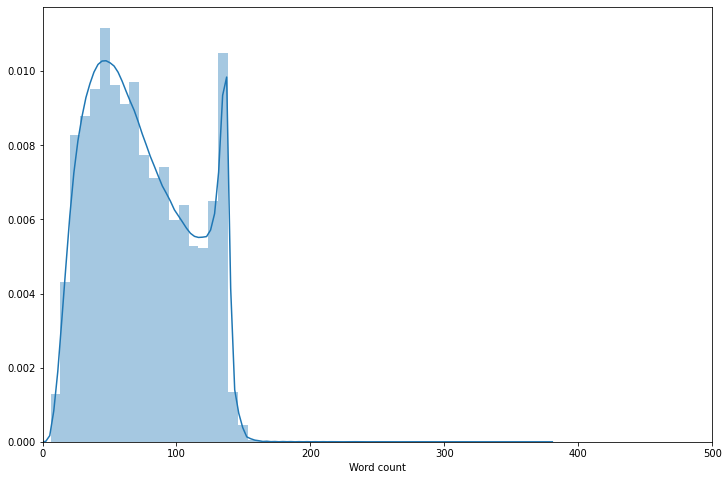

In [17]:
sns.distplot(word_lens)
plt.xlim([0, 500])
plt.xlabel('Word count')

Most tweets seem to be less than 200 words, so we'll be in the safe side and choose a maximum length of 400.

In [18]:
MAX_LEN = 400

In [19]:
print('Reviews with words beyond chosen longest review: {}'.format(sum([True if word > MAX_LEN else False for word in word_lens])))

Reviews with words beyond chosen longest review: 0


With these building blocks, we'll create a PyTorch dataset/data model.

In [20]:
class TweetDataset(Dataset):
  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
        tweet,
        truncation=True,
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return {
        'tweet_text': tweet,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }

We choose to return review texts to easily evaluate predictions from our model. Let's set machine readable targets and split the data.

In [21]:
# split data
df_train, df_test = train_test_split(
    tweet_data,
    test_size=0.5,
    random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((800000, 6), (400000, 6), (400000, 6))

Helper function to create data loaders.

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TweetDataset(
      tweets=df.tweet.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len     
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=9
  )

In [23]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

An example batch from the training data loader.

In [24]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [25]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 400])
torch.Size([8, 400])
torch.Size([8])


## Sentiment classification with BERT and Hugging Face
We have BertForSequenceClassification and BertForQuestionAnswering at our disposal among others, but here we will use BertModel and build a sentiment classifier on top of it.

In [26]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [27]:
bert_model.config.hidden_size

768

Creating a classifier using BERT model.

In [28]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

We use a dropout layer for some regularization and a fully connected layer for our output. We return the raw output of the last layer for crossentropy function in PyTorch to work.

In [29]:
sentiment_names = ['negative', 'positive']
model = SentimentClassifier(len(sentiment_names))
model = model.to(device)

Move example batch of training data to device.

In [30]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

# batch size x sequence length expected
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([8, 400])
torch.Size([8, 400])


To get predicted probabilities from our trained model, we'll apply the softmax function to the outputs.

In [31]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.6980, 0.3020],
        [0.7517, 0.2483],
        [0.6700, 0.3300],
        [0.8417, 0.1583],
        [0.7511, 0.2489],
        [0.6653, 0.3347],
        [0.7916, 0.2084],
        [0.5458, 0.4542]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training
We'll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We'll also use a linear scheduler with no warmup steps.

In [32]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

The BERT authors have suggestions for fine tuning parameters:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

**Note**: Increasing batch size reduces training time significantly, but gives lower accuracy.

We'll write a helper function for training our model for one epoch, and to evaluate our model on a given data loader.

In [33]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

We can now write the training loop using the two, and we'll save the training history.

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state.dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


We store the best model based on highest validation accuracy.

Plot training vs. validation accuracy.

In [1]:
plt.plot(history['train_acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])